## Notebook for visualizing attention score in vision encoders

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/daniel/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_image(path_or_url):
    if path_or_url.startswith('http'):
        image = Image.open(requests.get(path_or_url, stream=True).raw).convert('RGB')
    else:
        image = Image.open(path_or_url).convert('RGB')
    return image

def load_model(model_path):
    torch.cuda.empty_cache()
    model = AutoModel.from_pretrained(model_path, _attn_implementation="eager").to(device)
    processor = AutoProcessor.from_pretrained(model_path)
    print(f"Loaded model: {model_path} on {device}")
    return model, processor

def get_attention_maps(model, processor, image, include_cls_token=True):
    inputs = processor(images=image, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        try:
            outputs = model.vision_model(**inputs, output_attentions=True)
        except:
            outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # Tuple of (batch, heads, seq_len, seq_len)

    attention_maps = []
    for layer_attn in attentions:
        layer_avg_attn = layer_attn.mean(dim=1).squeeze(0)  # (seq_len, seq_len)
        
        if include_cls_token:
            attn_score = layer_avg_attn.sum(0)[1:]
        else:
            attn_score = layer_avg_attn.sum(0)
        
        # Transform into ranks for better visualization
        # [0.2, 0.4, 0.3, 0.1] -> [1, 3, 2, 0]
        attn_score = torch.argsort(torch.argsort(attn_score)).float()

        num_patches = int(np.sqrt(attn_score.shape[0]))
        attention_map = attn_score.reshape(num_patches, num_patches)
        # print(attention_map.shape)

        attention_map = F.interpolate(
            attention_map.unsqueeze(0).unsqueeze(0),
            size=image.size[::-1],  # (H, W)
            mode='nearest'
        ).squeeze().cpu().numpy()
        
        attention_maps.append(attention_map)
    
    return attention_maps

def show_attention_layers(image, attention_maps, layer_indices):
    num_layers = len(layer_indices)
    plt.figure(figsize=(5 * num_layers, 5))
    for i, layer_idx in enumerate(layer_indices):
        attention_map = attention_maps[layer_idx]
        plt.subplot(1, num_layers, i + 1)
        plt.imshow(image)
        plt.imshow(
            attention_map,
            cmap='plasma',
            alpha=0.5,
            interpolation='bilinear'
        )
        plt.title(f'Layer {layer_idx+1}')
        plt.axis('off')
    plt.tight_layout()

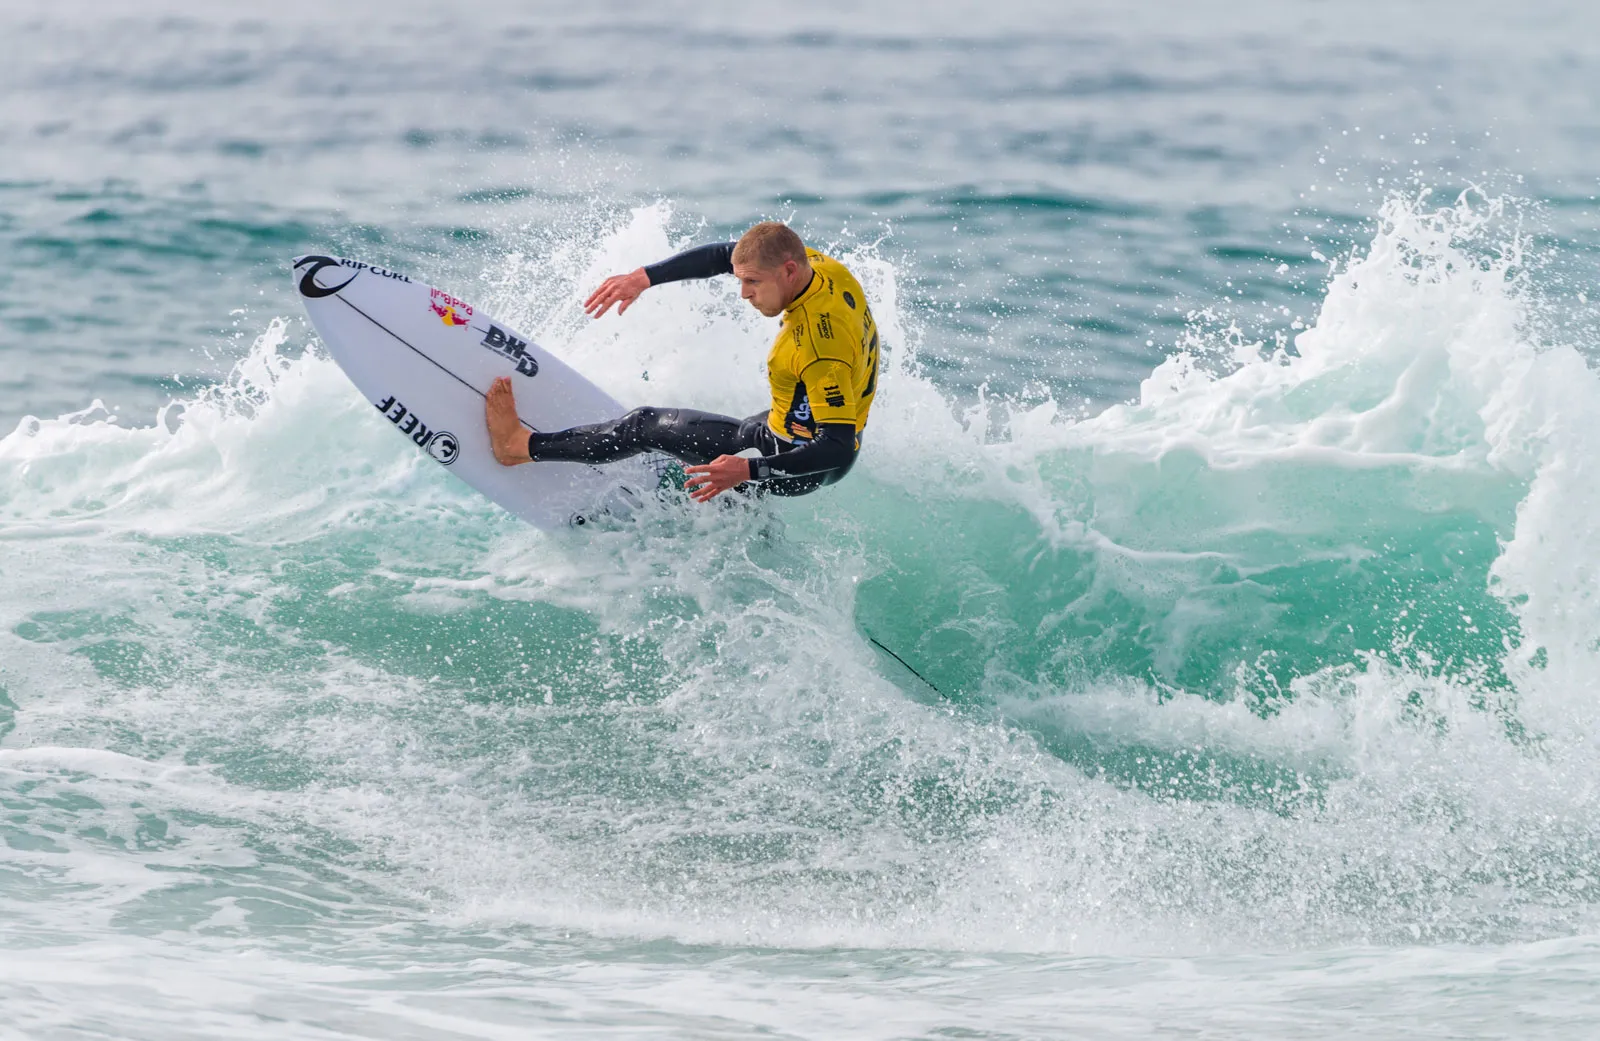

In [3]:
image = load_image("../assets/surf.webp")
image

### CLIP

In [4]:
model_path = "openai/clip-vit-large-patch14-336"

clip_model, clip_processor = load_model(model_path)
clip_model.config.vision_config.num_hidden_layers

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loaded model: openai/clip-vit-large-patch14-336 on cuda


24

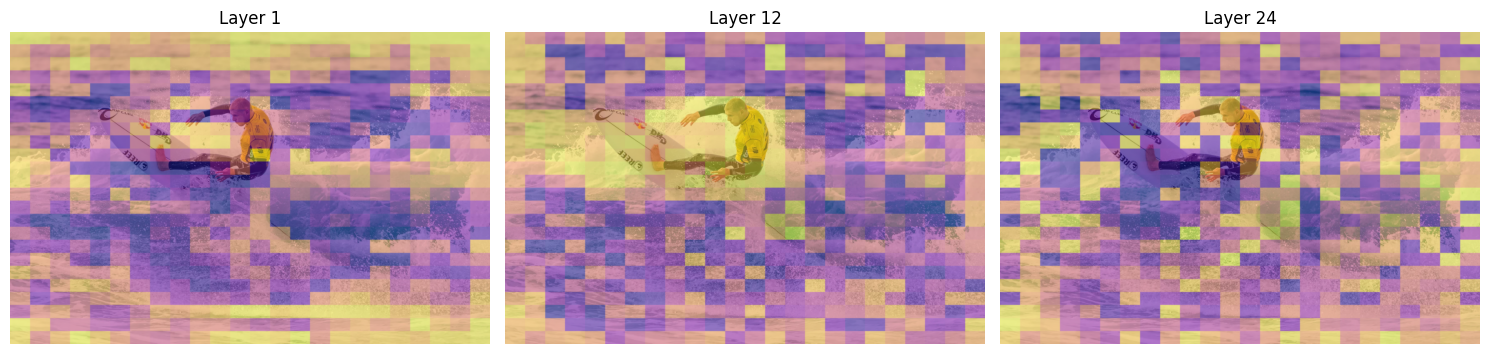

In [5]:
attention_maps = get_attention_maps(clip_model, clip_processor, image, include_cls_token=True)
show_attention_layers(image, attention_maps, layer_indices=[0, 11, 23])

### SigLIP

In [6]:
model_path = "google/siglip-so400m-patch14-384"

siglip_model, siglip_processor = load_model(model_path)
siglip_model.config.vision_config.num_hidden_layers

Loaded model: google/siglip-so400m-patch14-384 on cuda


27

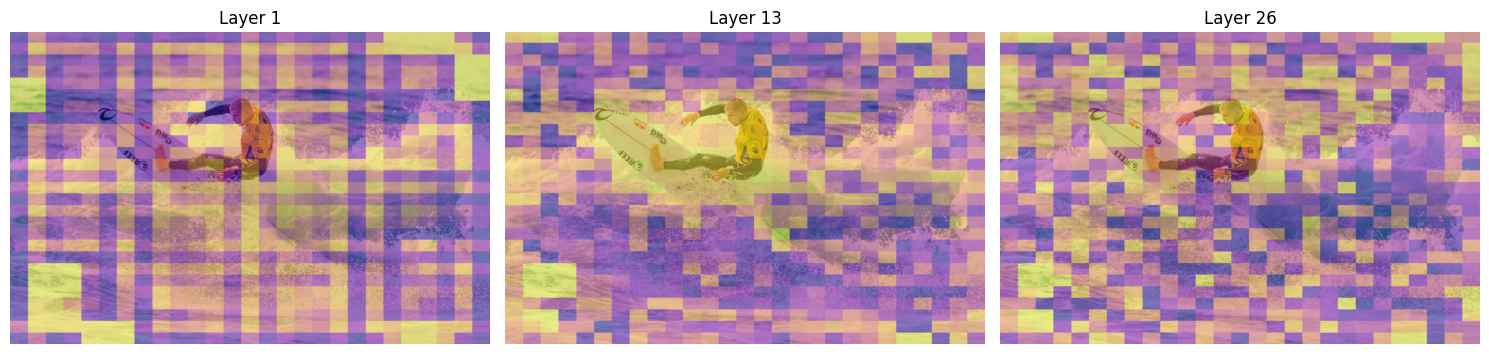

In [7]:
attention_maps = get_attention_maps(siglip_model, siglip_processor, image, include_cls_token=False)
show_attention_layers(image, attention_maps, layer_indices=[0, 12, 25])

### DeiT

In [8]:
model_path = "facebook/deit-base-patch16-224"

deit_model, deit_processor = load_model(model_path)
deit_model.config.num_hidden_layers

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model: facebook/deit-base-patch16-224 on cuda


12

/home/daniel/miniconda3/envs/py312/lib/python3.12/site-packages/transformers/image_processing_utils.py:44: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


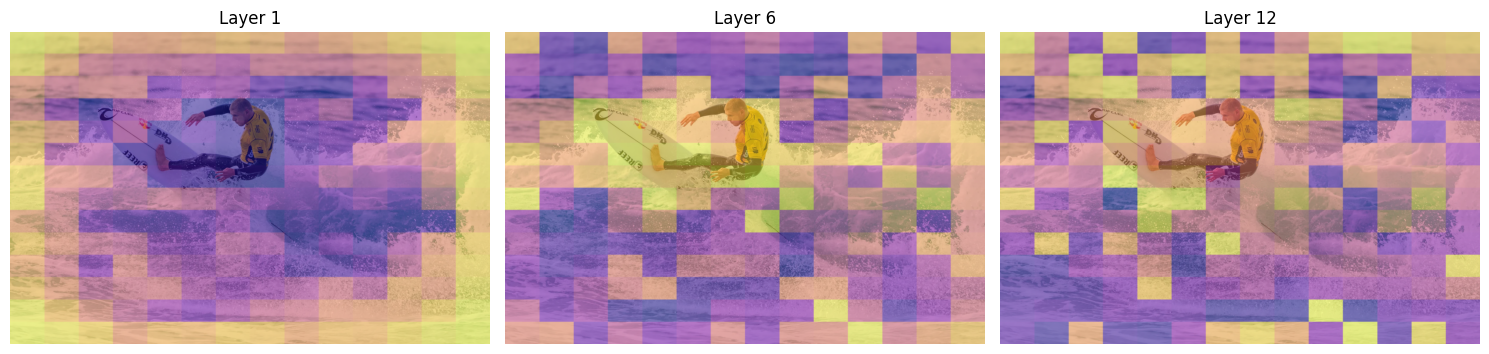

In [9]:
attention_maps = get_attention_maps(deit_model, deit_processor, image, include_cls_token=True)
show_attention_layers(image, attention_maps, layer_indices=[0, 5, 11])